In [3]:
# Install NumPy for handling .npz files and DuckDB for SQL queries
!pip install numpy duckdb


In [5]:
# Step 1: Load the .npz file
import numpy as np
import pandas as pd
import duckdb

file_path = r"C:\Users\mathe\Downloads\ml-20mx16x32\ml-20mx16x32\testx16x32_0.npz"
data = np.load(file_path)

# Step 2: Inspect the array
array = data['arr_0']
print("Array shape:", array.shape)
print("First 5 rows:\n", array[:5])

# Step 3: Convert to DataFrame with correct column names
# Since the array has 2 columns, we assume it's [userId, movieId]
ratings = pd.DataFrame(array, columns=['userId', 'movieId'])
print("Ratings DataFrame preview:\n", ratings.head())

# Step 4: Query with DuckDB
import duckdb
con = duckdb.connect()
con.register('ratings', ratings)

# Step 5: Count how many times each movie was rated
result = con.execute("""
    SELECT movieId, COUNT(*) AS num_ratings
    FROM ratings
    GROUP BY movieId
    ORDER BY num_ratings DESC
    LIMIT 10
""").fetchdf()

print("Most rated movies:\n", result)


Array shape: (138240, 2)
First 5 rows:
 [[     0 132972]
 [     1 103307]
 [     2  49200]
 [     3  37204]
 [     4  33377]]
Ratings DataFrame preview:
    userId  movieId
0       0   132972
1       1   103307
2       2    49200
3       3    37204
4       4    33377
Most rated movies:
    movieId  num_ratings
0    29824          179
1   108106          162
2   112895          160
3    30237          158
4   110836          157
5   114169          150
6   113480          150
7    36931          144
8   118205          144
9    31911          137


In [7]:
# Ver nomes das colunas e tipos
schema_info = con.execute("DESCRIBE ratings").fetchdf()
print("Schema da tabela ratings:\n", schema_info)

# Ver primeiras linhas
preview = con.execute("SELECT * FROM ratings LIMIT 10").fetchdf()
print("\nPreview dos dados:\n", preview)

# Contagem total de linhas
row_count = con.execute("SELECT COUNT(*) AS total_rows FROM ratings").fetchdf()
print("\nTotal de linhas:\n", row_count)

# Estatísticas básicas por coluna
stats = con.execute("""
    SELECT 
        COUNT(*) AS total,
        MIN(userId) AS min_user,
        MAX(userId) AS max_user,
        MIN(movieId) AS min_movie,
        MAX(movieId) AS max_movie
    FROM ratings
""").fetchdf()
print("\nEstatísticas básicas:\n", stats)

Schema da tabela ratings:
   column_name column_type null   key default extra
0      userId      BIGINT  YES  None    None  None
1     movieId      BIGINT  YES  None    None  None

Preview dos dados:
    userId  movieId
0       0   132972
1       1   103307
2       2    49200
3       3    37204
4       4    33377
5       5    47873
6       6   162285
7       7   148595
8       8   194439
9       9   114374

Total de linhas:
    total_rows
0      138240

Estatísticas básicas:
     total  min_user  max_user  min_movie  max_movie
0  138240         0    138239          2     240675


In [ ]:
# =============================================================================
# Title: MovieLens 10M - End-to-end EDA + Baseline Modeling with DuckDB and Pandas
# Author: Matheus (Jupyter Notebook)
# Description:
#   This single cell will:
#     1) Install runtime dependencies (duckdb, pandas, pyarrow)
#     2) Load MovieLens 10M files (ratings.dat, movies.dat, tags.dat) with '::' delimiter (UTF-8)
#     3) Create DuckDB database and tables
#     4) Run descriptive statistics and exploratory SQL analyses
#     5) Create evaluation splits (user-wise random 80/20 and temporal 80/20)
#     6) Train a simple baseline predictive model (global mean + item bias + user bias) and compute RMSE
# Notes:
#   - All code comments and section titles are in English, per your request.
#   - The .dat files are assumed to be located in the Windows paths provided below.
#   - The baseline model is lightweight and serves as a strong starting point.
# =============================================================================

# === 0) Setup & Imports =======================================================
# Install required packages in the Jupyter environment (quiet mode).
# If you already have them, you may safely ignore this cell step.
import sys
if 'duckdb' not in sys.modules:
    # Jupyter-friendly installation (silent)
    try:
        get_ipython().run_line_magic('pip', 'install -q duckdb pandas pyarrow')
    except Exception as e:
        print("Optional install step failed or was skipped:", e)

import duckdb
import pandas as pd
import numpy as np
from IPython.display import display

# === 1) Paths: adjust if your folder layout differs ===========================
DATA_DIR   = r"C:\Users\mathe\Downloads\ml-10m\ml-10M100K"
PATH_RAT   = fr"{DATA_DIR}\ratings.dat"
PATH_MOV   = fr"{DATA_DIR}\movies.dat"
PATH_TAG   = fr"{DATA_DIR}\tags.dat"
DB_FILE    = "movielens.duckdb"   # local DuckDB database file

# === 2) Load .dat files with '::' delimiter ===================================
# We use pandas with engine='python' to support multi-character delimiter '::'.
# All files are UTF-8 as per the official README.
ratings = pd.read_csv(
    PATH_RAT, sep='::', engine='python', encoding='utf-8',
    names=['userId','movieId','rating','timestamp']
)
movies = pd.read_csv(
    PATH_MOV, sep='::', engine='python', encoding='utf-8',
    names=['movieId','title','genres']
)
tags = pd.read_csv(
    PATH_TAG, sep='::', engine='python', encoding='utf-8',
    names=['userId','movieId','tag','timestamp']
)

# Cast useful dtypes for memory efficiency and consistency
ratings['userId']  = ratings['userId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating']  = ratings['rating'].astype('float32')
# timestamps kept as int64 (seconds since epoch)

movies['movieId'] = movies['movieId'].astype('int32')
movies['title']   = movies['title'].astype('string')
movies['genres']  = movies['genres'].astype('string')

tags['userId']    = tags['userId'].astype('int32')
tags['movieId']   = tags['movieId'].astype('int32')
tags['tag']       = tags['tag'].astype('string')
# timestamps kept as int64 (seconds since epoch)

# Quick sanity checks
print("Shapes:", ratings.shape, movies.shape, tags.shape)
display(ratings.head(3))
display(movies.head(3))
display(tags.head(3))

# === 3) Create DuckDB database & tables =======================================
# Connects/creates a local DuckDB file. Registers pandas DataFrames and persists as tables.
con = duckdb.connect(DB_FILE)
con.register('ratings_df', ratings)
con.register('movies_df', movies)
con.register('tags_df', tags)

# Create or replace persistent tables (columnar, fast scans).
con.execute("CREATE OR REPLACE TABLE ratings AS SELECT * FROM ratings_df")
con.execute("CREATE OR REPLACE TABLE movies  AS SELECT * FROM movies_df")
con.execute("CREATE OR REPLACE TABLE tags    AS SELECT * FROM tags_df")

# === 4) Schema inspection & quick previews ===================================
print("\n-- SCHEMA: ratings --")
display(con.execute("DESCRIBE ratings").df())
print("\n-- SCHEMA: movies --")
display(con.execute("DESCRIBE movies").df())
print("\n-- SCHEMA: tags --")
display(con.execute("DESCRIBE tags").df())

print("\n-- PREVIEW: ratings --")
display(con.execute("SELECT * FROM ratings LIMIT 5").df())
print("\n-- PREVIEW: movies --")
display(con.execute("SELECT * FROM movies  LIMIT 5").df())
print("\n-- PREVIEW: tags --")
display(con.execute("SELECT * FROM tags    LIMIT 5").df())

# === 5) Global overview counts ===============================================
# Counts for ratings, unique users/items, and tags.
overview = con.execute("""
WITH
  c AS (SELECT COUNT(*) AS n_ratings FROM ratings),
  u AS (SELECT COUNT(DISTINCT userId) AS n_users FROM ratings),
  m AS (SELECT COUNT(DISTINCT movieId) AS n_movies FROM ratings),
  t AS (SELECT COUNT(*) AS n_tags FROM tags)
SELECT c.n_ratings, u.n_users, m.n_movies, t.n_tags FROM c,u,m,t
""").df()
print("\n-- OVERVIEW --")
display(overview)

# === 6) Descriptive statistics: ratings distribution & summary ===============
# 6.1 Distribution of rating values (0.5 increments up to 5.0)
print("\n-- DISTRIBUTION: rating counts --")
display(con.execute("""
SELECT rating, COUNT(*) AS n
FROM ratings
GROUP BY rating
ORDER BY rating
""").df())

# 6.2 Summary statistics including temporal coverage
print("\n-- SUMMARY: ratings + temporal coverage --")
display(con.execute("""
SELECT
  COUNT(*)                              AS n_ratings,
  MIN(rating)                           AS min_rating,
  MAX(rating)                           AS max_rating,
  AVG(rating)                           AS mean_rating,
  STDDEV_SAMP(rating)                   AS sd_rating,
  MIN(timestamp)                        AS min_ts,
  MAX(timestamp)                        AS max_ts,
  DATE_TRUNC('day', TO_TIMESTAMP(MIN(timestamp))) AS first_date,
  DATE_TRUNC('day', TO_TIMESTAMP(MAX(timestamp))) AS last_date
FROM ratings
""").df())

# === 7) User activity stats (distribution and quantiles) ======================
print("\n-- USER ACTIVITY: counts per user + quantiles --")
display(con.execute("""
WITH per_user AS (
  SELECT userId, COUNT(*) AS n
  FROM ratings
  GROUP BY userId
)
SELECT 
  COUNT(*)                      AS n_users,
  MIN(n)                        AS min_ratings_user,
  MAX(n)                        AS max_ratings_user,
  AVG(n)                        AS avg_ratings_user,
  QUANTILE_CONT(n, 0.5)         AS p50,
  QUANTILE_CONT(n, 0.9)         AS p90,
  QUANTILE_CONT(n, 0.99)        AS p99
FROM per_user
""").df())

# === 8) Item (movie) popularity and stats =====================================
print("\n-- TOP-20 MOVIES by number of ratings (with mean and SD) --")
display(con.execute("""
SELECT 
  r.movieId,
  m.title,
  COUNT(*)                      AS num_ratings,
  AVG(r.rating)                 AS mean_rating,
  STDDEV_SAMP(r.rating)         AS sd_rating
FROM ratings r
JOIN movies  m USING(movieId)
GROUP BY r.movieId, m.title
ORDER BY num_ratings DESC
LIMIT 20
""").df())

# === 9) Temporal trends: ratings per year =====================================
print("\n-- TEMPORAL TRENDS: ratings per year + mean rating --")
display(con.execute("""
SELECT 
  EXTRACT(YEAR FROM TO_TIMESTAMP(timestamp)) AS year,
  COUNT(*) AS n_ratings,
  AVG(rating) AS mean_rating
FROM ratings
GROUP BY year
ORDER BY year
""").df())

# === 10) Genres: explode pipe-separated list and aggregate ====================
print("\n-- GENRES: number of movies per genre --")
display(con.execute("""
WITH exploded AS (
  SELECT movieId, UNNEST(STR_SPLIT(genres, '|')) AS genre
  FROM movies
)
SELECT genre, COUNT(*) AS n_movies
FROM exploded
WHERE genre IS NOT NULL AND genre <> '(no genres listed)'
GROUP BY genre
ORDER BY n_movies DESC
""").df())

# === 11) Titles with missing/redundant year patterns (data quality check) =====
print("\n-- DATA QUALITY: titles where year extraction fails (first 20) --")
display(con.execute(r"""
SELECT 
  movieId, 
  title,
  REGEXP_EXTRACT(title, '\((\d{4})\)$', 1) AS year_str
FROM movies
WHERE year_str IS NULL
LIMIT 20
""").df())

# === 12) Tags: most frequent tags ============================================
print("\n-- TAGS: top-20 most frequent tags --")
display(con.execute("""
SELECT LOWER(TRIM(tag)) AS tag_norm, COUNT(*) AS n
FROM tags
GROUP BY tag_norm
ORDER BY n DESC
LIMIT 20
""").df())

# === 13) Matrix density (sparsity) ===========================================
print("\n-- SPARSITY: matrix user x movie density --")
display(con.execute("""
WITH stats AS (
  SELECT 
    (SELECT COUNT(*) FROM ratings)               AS n_ratings,
    (SELECT COUNT(DISTINCT userId) FROM ratings) AS n_users,
    (SELECT COUNT(DISTINCT movieId) FROM ratings)AS n_items
)
SELECT 
  n_ratings, n_users, n_items,
  1.0 * n_ratings / (n_users * n_items) AS density
FROM stats
""").df())

# === 14) Create evaluation splits (user-wise random 80/20 and temporal 80/20) ==
print("\n-- SPLITS: creating user-wise random 80/20 (rating_splits) --")
con.execute("""
CREATE OR REPLACE TABLE rating_splits AS
WITH per_user AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY userId ORDER BY RANDOM()) AS rn,
    COUNT(*)     OVER (PARTITION BY userId)                    AS cnt
  FROM ratings
)
SELECT 
  userId, movieId, rating, timestamp,
  CASE WHEN rn <= 0.8 * cnt THEN 'train' ELSE 'test' END AS split
FROM per_user
""")

print("\n-- SPLITS: creating temporal 80/20 (rating_splits_time) --")
con.execute("""
CREATE OR REPLACE TABLE rating_splits_time AS
WITH per_user AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY userId ORDER BY timestamp) AS rn,
    COUNT(*)     OVER (PARTITION BY userId)                    AS cnt
  FROM ratings
)
SELECT 
  userId, movieId, rating, timestamp,
  CASE WHEN rn <= 0.8 * cnt THEN 'train' ELSE 'test' END AS split
FROM per_user
""")

# Quick split sanity check
print("\n-- SPLITS SUMMARY (random 80/20) --")
display(con.execute("""
SELECT split, COUNT(*) AS n, AVG(rating) AS mean_rating
FROM rating_splits
GROUP BY split
ORDER BY split
""").df())

# === 15) Baseline predictive model: global mean + item bias + user bias =======
# This is a strong, lightweight baseline for rating prediction (explicit feedback).
# We solve for item/user biases with iterative closed-form updates (regularized).
print("\n-- BASELINE MODEL: training (this may take ~tens of seconds) --")

# Bring split to pandas (only random split used for modeling here)
split_df = con.execute("SELECT * FROM rating_splits").df()

train = split_df[split_df['split'] == 'train'][['userId','movieId','rating']].copy()
test  = split_df[split_df['split'] == 'test' ][['userId','movieId','rating']].copy()

# Global mean
mu = train['rating'].mean()

# Initialize biases
bu = pd.Series(0.0, index=train['userId'].unique(), dtype='float32')  # user bias
bi = pd.Series(0.0, index=train['movieId'].unique(), dtype='float32') # item bias

# Regularization strength
reg = 10.0

# Iterative alternating updates (items then users)
# b_i = sum_u (r_ui - mu - b_u) / (reg + |U_i|)
# b_u = sum_i (r_ui - mu - b_i) / (reg + |I_u|)
for epoch in range(8):  # a few epochs are enough for the baseline
    # Update item biases
    # Residuals using current user biases
    bu_map = train['userId'].map(bu).fillna(0.0).astype('float32')
    res_i = train['rating'] - mu - bu_map
    tmp_i = pd.DataFrame({'movieId': train['movieId'].values, 'res': res_i.values})
    agg_i = tmp_i.groupby('movieId').agg(sum_res=('res','sum'), count=('res','size'))
    bi = (agg_i['sum_res'] / (reg + agg_i['count'])).astype('float32')

    # Update user biases
    bi_map = train['movieId'].map(bi).fillna(0.0).astype('float32')
    res_u = train['rating'] - mu - bi_map
    tmp_u = pd.DataFrame({'userId': train['userId'].values, 'res': res_u.values})
    agg_u = tmp_u.groupby('userId').agg(sum_res=('res','sum'), count=('res','size'))
    bu = (agg_u['sum_res'] / (reg + agg_u['count'])).astype('float32')
    print(f"  epoch {epoch+1} done.")

# Predictions on test
pred = (
    mu
    + test['userId'].map(bu).fillna(0.0).astype('float32')
    + test['movieId'].map(bi).fillna(0.0).astype('float32')
)
# Clip predictions to rating scale [0.5, 5.0]
pred = pred.clip(lower=0.5, upper=5.0)

# RMSE
rmse = np.sqrt(np.mean((test['rating'].astype('float32') - pred)**2))
print(f"\n-- BASELINE RMSE (user-wise random 80/20): {rmse:.4f}")

# === 16) Optional: export to Parquet for future fast loads ====================
# Uncomment to persist columnar files
# con.execute("COPY ratings TO 'ratings.parquet' (FORMAT PARQUET)")
# con.execute("COPY movies  TO 'movies.parquet'  (FORMAT PARQUET)")
# con.execute("COPY tags    TO 'tags.parquet'    (FORMAT PARQUET)")

# === 17) Notes on next modeling steps (kept as comments) ======================
# - To try stronger models:
#   * Surprise (SVD/SVD++): pip install scikit-surprise
#   * Implicit feedback (BPR-MF, ALS): pip install implicit
#   * Hybrid (content + collaborative) with LightFM: pip install lightfm
# - For ranking tasks (Recall@K, NDCG@K), binarize interactions (e.g., rating >= 3.5)
#   and evaluate Top-N recommendations per user.
# - Consider temporal splits (rating_splits_time) to reduce leakage from the future.
# - Add content features (genres, TF-IDF of tags) to mitigate cold start.


In [9]:
# =============================================================================
# Title: MovieLens 10M - End-to-end EDA + Baseline Modeling with DuckDB and Pandas
# Author: Matheus (Jupyter Notebook)
# Description:
#   This single cell will:
#     1) Install runtime dependencies (duckdb, pandas, pyarrow)
#     2) Load MovieLens 10M files (ratings.dat, movies.dat, tags.dat) with '::' delimiter (UTF-8)
#     3) Create DuckDB database and tables
#     4) Run descriptive statistics and exploratory SQL analyses
#     5) Create evaluation splits (user-wise random 80/20 and temporal 80/20)
#     6) Train a simple baseline predictive model (global mean + item bias + user bias) and compute RMSE
# Notes:
#   - All code comments and section titles are in English, per your request.
#   - The .dat files are assumed to be located in the Windows paths provided below.
#   - The baseline model is lightweight and serves as a strong starting point.
# =============================================================================

# === 0) Setup & Imports =======================================================
# Install required packages in the Jupyter environment (quiet mode).
# If you already have them, you may safely ignore this cell step.
import sys
if 'duckdb' not in sys.modules:
    # Jupyter-friendly installation (silent)
    try:
        get_ipython().run_line_magic('pip', 'install -q duckdb pandas pyarrow')
    except Exception as e:
        print("Optional install step failed or was skipped:", e)

import duckdb
import pandas as pd
import numpy as np
from IPython.display import display

# === 1) Paths: adjust if your folder layout differs ===========================
DATA_DIR   = r"C:\Users\mathe\Downloads\ml-10m\ml-10M100K"
PATH_RAT   = fr"{DATA_DIR}\ratings.dat"
PATH_MOV   = fr"{DATA_DIR}\movies.dat"
PATH_TAG   = fr"{DATA_DIR}\tags.dat"
DB_FILE    = "movielens.duckdb"   # local DuckDB database file

# === 2) Load .dat files with '::' delimiter ===================================
# We use pandas with engine='python' to support multi-character delimiter '::'.
# All files are UTF-8 as per the official README.
ratings = pd.read_csv(
    PATH_RAT, sep='::', engine='python', encoding='utf-8',
    names=['userId','movieId','rating','timestamp']
)
movies = pd.read_csv(
    PATH_MOV, sep='::', engine='python', encoding='utf-8',
    names=['movieId','title','genres']
)
tags = pd.read_csv(
    PATH_TAG, sep='::', engine='python', encoding='utf-8',
    names=['userId','movieId','tag','timestamp']
)

# Cast useful dtypes for memory efficiency and consistency
ratings['userId']  = ratings['userId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating']  = ratings['rating'].astype('float32')
# timestamps kept as int64 (seconds since epoch)

movies['movieId'] = movies['movieId'].astype('int32')
movies['title']   = movies['title'].astype('string')
movies['genres']  = movies['genres'].astype('string')

tags['userId']    = tags['userId'].astype('int32')
tags['movieId']   = tags['movieId'].astype('int32')
tags['tag']       = tags['tag'].astype('string')
# timestamps kept as int64 (seconds since epoch)

# Quick sanity checks
print("Shapes:", ratings.shape, movies.shape, tags.shape)
display(ratings.head(3))
display(movies.head(3))
display(tags.head(3))

Shapes: (10000054, 4) (10681, 3) (95580, 4)


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867


In [11]:
# === 3) Create DuckDB database & tables =======================================
# Connects/creates a local DuckDB file. Registers pandas DataFrames and persists as tables.
con = duckdb.connect(DB_FILE)
con.register('ratings_df', ratings)
con.register('movies_df', movies)
con.register('tags_df', tags)

# Create or replace persistent tables (columnar, fast scans).
con.execute("CREATE OR REPLACE TABLE ratings AS SELECT * FROM ratings_df")
con.execute("CREATE OR REPLACE TABLE movies  AS SELECT * FROM movies_df")
con.execute("CREATE OR REPLACE TABLE tags    AS SELECT * FROM tags_df")

In [13]:
# === 4) Schema inspection & quick previews ===================================
print("\n-- SCHEMA: ratings --")
display(con.execute("DESCRIBE ratings").df())
print("\n-- SCHEMA: movies --")
display(con.execute("DESCRIBE movies").df())
print("\n-- SCHEMA: tags --")
display(con.execute("DESCRIBE tags").df())

print("\n-- PREVIEW: ratings --")
display(con.execute("SELECT * FROM ratings LIMIT 5").df())
print("\n-- PREVIEW: movies --")
display(con.execute("SELECT * FROM movies  LIMIT 5").df())
print("\n-- PREVIEW: tags --")
display(con.execute("SELECT * FROM tags    LIMIT 5").df())


-- SCHEMA: ratings --


,column_name,column_type,null,key,default,extra
0,userId,INTEGER,YES,None,None,None
1,movieId,INTEGER,YES,None,None,None
2,rating,FLOAT,YES,None,None,None
3,timestamp,BIGINT,YES,None,None,None



-- SCHEMA: movies --


,column_name,column_type,null,key,default,extra
0,movieId,INTEGER,YES,None,None,None
1,title,VARCHAR,YES,None,None,None
2,genres,VARCHAR,YES,None,None,None



-- SCHEMA: tags --


,column_name,column_type,null,key,default,extra
0,userId,INTEGER,YES,None,None,None
1,movieId,INTEGER,YES,None,None,None
2,tag,VARCHAR,YES,None,None,None
3,timestamp,BIGINT,YES,None,None,None



-- PREVIEW: ratings --


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392



-- PREVIEW: movies --


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



-- PREVIEW: tags --


,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [15]:
# === 5) Global overview counts ===============================================
# Counts for ratings, unique users/items, and tags.
overview = con.execute("""
WITH
  c AS (SELECT COUNT(*) AS n_ratings FROM ratings),
  u AS (SELECT COUNT(DISTINCT userId) AS n_users FROM ratings),
  m AS (SELECT COUNT(DISTINCT movieId) AS n_movies FROM ratings),
  t AS (SELECT COUNT(*) AS n_tags FROM tags)
SELECT c.n_ratings, u.n_users, m.n_movies, t.n_tags FROM c,u,m,t
""").df()
print("\n-- OVERVIEW --")
display(overview)

# === 6) Descriptive statistics: ratings distribution & summary ===============
# 6.1 Distribution of rating values (0.5 increments up to 5.0)
print("\n-- DISTRIBUTION: rating counts --")
display(con.execute("""
SELECT rating, COUNT(*) AS n
FROM ratings
GROUP BY rating
ORDER BY rating
""").df())

# 6.2 Summary statistics including temporal coverage
print("\n-- SUMMARY: ratings + temporal coverage --")
display(con.execute("""
SELECT
  COUNT(*)                              AS n_ratings,
  MIN(rating)                           AS min_rating,
  MAX(rating)                           AS max_rating,
  AVG(rating)                           AS mean_rating,
  STDDEV_SAMP(rating)                   AS sd_rating,
  MIN(timestamp)                        AS min_ts,
  MAX(timestamp)                        AS max_ts,
  DATE_TRUNC('day', TO_TIMESTAMP(MIN(timestamp))) AS first_date,
  DATE_TRUNC('day', TO_TIMESTAMP(MAX(timestamp))) AS last_date
FROM ratings
""").df())


-- OVERVIEW --


,n_ratings,n_users,n_movies,n_tags
0,10000054,69878,10677,95580



-- DISTRIBUTION: rating counts --


,rating,n
0,0.5,94988
1,1.0,384180
2,1.5,118278
3,2.0,790306
4,2.5,370178
5,3.0,2356676
6,3.5,879764
7,4.0,2875850
8,4.5,585022
9,5.0,1544812



-- SUMMARY: ratings + temporal coverage --


,n_ratings,min_rating,max_rating,mean_rating,sd_rating,min_ts,max_ts,first_date,last_date
0,10000054,0.5,5.0,3.512422,1.060418,789652009,1231131736,1995-01-09 00:00:00+00:00,2009-01-05 00:00:00+00:00


In [19]:
# === 7) User activity stats (distribution and quantiles) ======================
print("\n-- USER ACTIVITY: counts per user + quantiles --")
display(con.execute("""
WITH per_user AS (
  SELECT userId, COUNT(*) AS n
  FROM ratings
  GROUP BY userId
)
SELECT 
  COUNT(*)                      AS n_users,
  MIN(n)                        AS min_ratings_user,
  MAX(n)                        AS max_ratings_user,
  AVG(n)                        AS avg_ratings_user,
  QUANTILE_CONT(n, 0.5)         AS p50,
  QUANTILE_CONT(n, 0.9)         AS p90,
  QUANTILE_CONT(n, 0.99)        AS p99
FROM per_user
""").df())

# === 8) Item (movie) popularity and stats =====================================
print("\n-- TOP-20 MOVIES by number of ratings (with mean and SD) --")
display(con.execute("""
SELECT 
  r.movieId,
  m.title,
  COUNT(*)                      AS num_ratings,
  AVG(r.rating)                 AS mean_rating,
  STDDEV_SAMP(r.rating)         AS sd_rating
FROM ratings r
JOIN movies  m USING(movieId)
GROUP BY r.movieId, m.title
ORDER BY num_ratings DESC
LIMIT 20
""").df())

# === 9) Temporal trends: ratings per year =====================================
print("\n-- TEMPORAL TRENDS: ratings per year + mean rating --")
display(con.execute("""
SELECT 
  EXTRACT(YEAR FROM TO_TIMESTAMP(timestamp)) AS year,
  COUNT(*) AS n_ratings,
  AVG(rating) AS mean_rating
FROM ratings
GROUP BY year
ORDER BY year
""").df())

# === 10) Genres: explode pipe-separated list and aggregate ====================
print("\n-- GENRES: number of movies per genre --")
display(con.execute("""
WITH exploded AS (
  SELECT movieId, UNNEST(STR_SPLIT(genres, '|')) AS genre
  FROM movies
)
SELECT genre, COUNT(*) AS n_movies
FROM exploded
WHERE genre IS NOT NULL AND genre <> '(no genres listed)'
GROUP BY genre
ORDER BY n_movies DESC
""").df())




-- USER ACTIVITY: counts per user + quantiles --


,n_users,min_ratings_user,max_ratings_user,avg_ratings_user,p50,p90,p99
0,69878,20,7359,143.10733,69.0,335.0,1058.23



-- TOP-20 MOVIES by number of ratings (with mean and SD) --


,movieId,title,num_ratings,mean_rating,sd_rating
0,296,Pulp Fiction (1994),34864,4.157426,1.002503
1,356,Forrest Gump (1994),34457,4.013582,0.968450
2,593,"Silence of the Lambs, The (1991)",33668,4.204200,0.838269
3,480,Jurassic Park (1993),32631,3.661564,0.938579
4,318,"Shawshank Redemption, The (1994)",31126,4.457238,0.716228
5,110,Braveheart (1995),29154,4.082390,0.952452
6,457,"Fugitive, The (1993)",28951,4.006925,0.775496
7,589,Terminator 2: Judgment Day (1991),28948,3.927698,0.905484
8,260,Star Wars: Episode IV - A New Hope (a.k.a. Sta...,28566,4.220209,0.914123
9,150,Apollo 13 (1995),27035,3.887350,0.852143



-- TEMPORAL TRENDS: ratings per year + mean rating --


,year,n_ratings,mean_rating
0,1995,3,3.666667
1,1996,1047618,3.544665
2,1997,459947,3.585413
3,1998,202092,3.506744
4,1999,788793,3.617680
5,2000,1271623,3.578344
6,2001,759141,3.536600
7,2002,583409,3.472127
8,2003,688694,3.471945
9,2004,768168,3.425808



-- GENRES: number of movies per genre --


,genre,n_movies
0,Drama,5339
1,Comedy,3703
2,Thriller,1706
3,Romance,1685
4,Action,1473
5,Crime,1118
6,Adventure,1025
7,Horror,1013
8,Sci-Fi,754
9,Fantasy,543


In [21]:
# === 11) Titles with missing/redundant year patterns (data quality check) =====
print("\n-- DATA QUALITY: titles where year extraction fails (first 20) --")
display(con.execute(r"""
SELECT 
  movieId, 
  title,
  REGEXP_EXTRACT(title, '\((\d{4})\)$', 1) AS year_str
FROM movies
WHERE year_str IS NULL
LIMIT 20
""").df())

# === 12) Tags: most frequent tags ============================================
print("\n-- TAGS: top-20 most frequent tags --")
display(con.execute("""
SELECT LOWER(TRIM(tag)) AS tag_norm, COUNT(*) AS n
FROM tags
GROUP BY tag_norm
ORDER BY n DESC
LIMIT 20
""").df())

# === 13) Matrix density (sparsity) ===========================================
print("\n-- SPARSITY: matrix user x movie density --")
display(con.execute("""
WITH stats AS (
  SELECT 
    (SELECT COUNT(*) FROM ratings)               AS n_ratings,
    (SELECT COUNT(DISTINCT userId) FROM ratings) AS n_users,
    (SELECT COUNT(DISTINCT movieId) FROM ratings)AS n_items
)
SELECT 
  n_ratings, n_users, n_items,
  1.0 * n_ratings / (n_users * n_items) AS density
FROM stats
""").df())


-- DATA QUALITY: titles where year extraction fails (first 20) --


,movieId,title,year_str



-- TAGS: top-20 most frequent tags --


,tag_norm,n
0,classic,718
1,tumey's dvds,641
2,based on a book,555
3,r,518
4,less than 300 ratings,505
5,comedy,484
6,action,479
7,nudity (topless),466
8,70mm,464
9,dvd,433



-- SPARSITY: matrix user x movie density --


,n_ratings,n_users,n_items,density
0,10000054,69878,10677,0.013403


-- Overview (from README-consistent structure) --


,n_ratings,n_users,n_movies,n_tags
0,10000054,69878,10681,95580


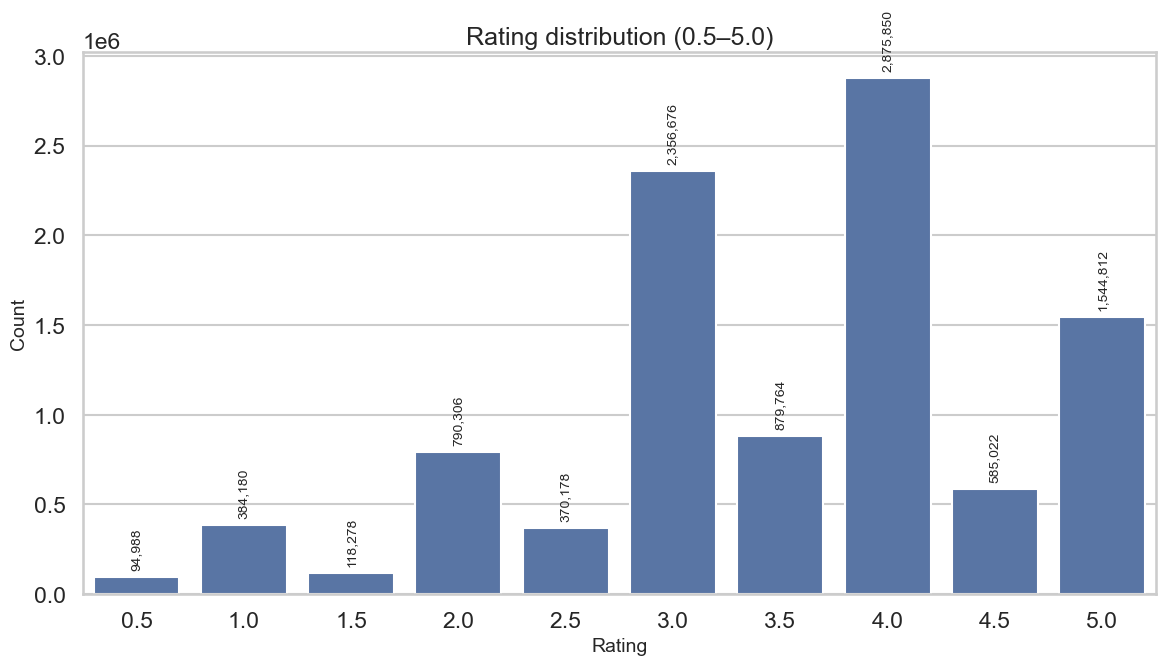

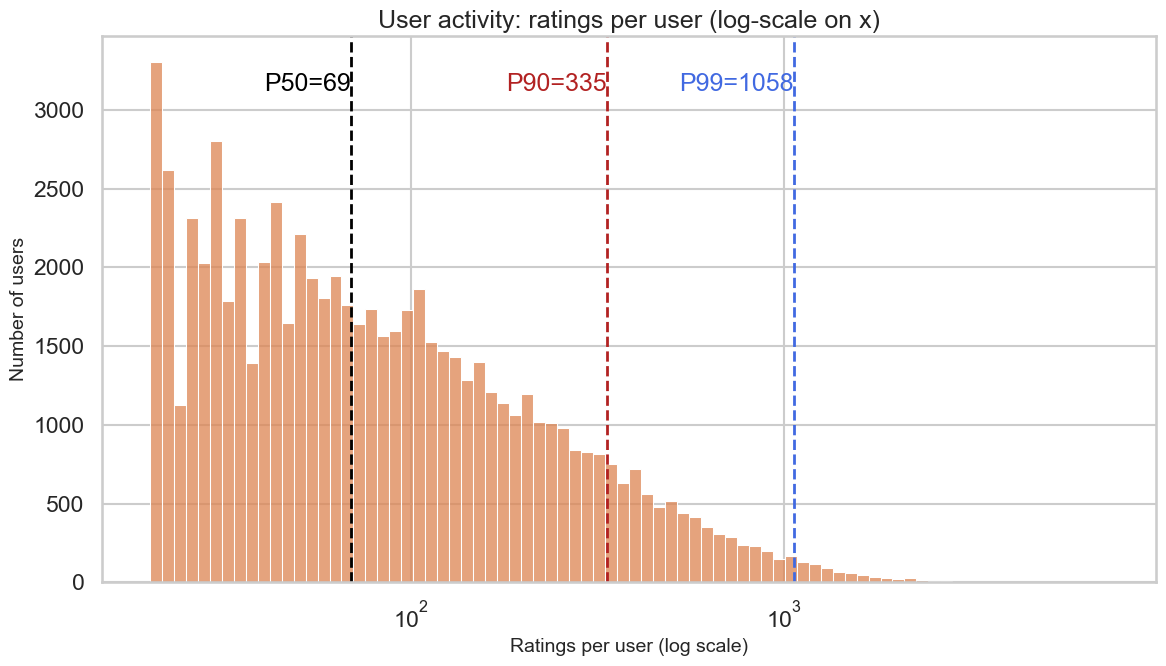

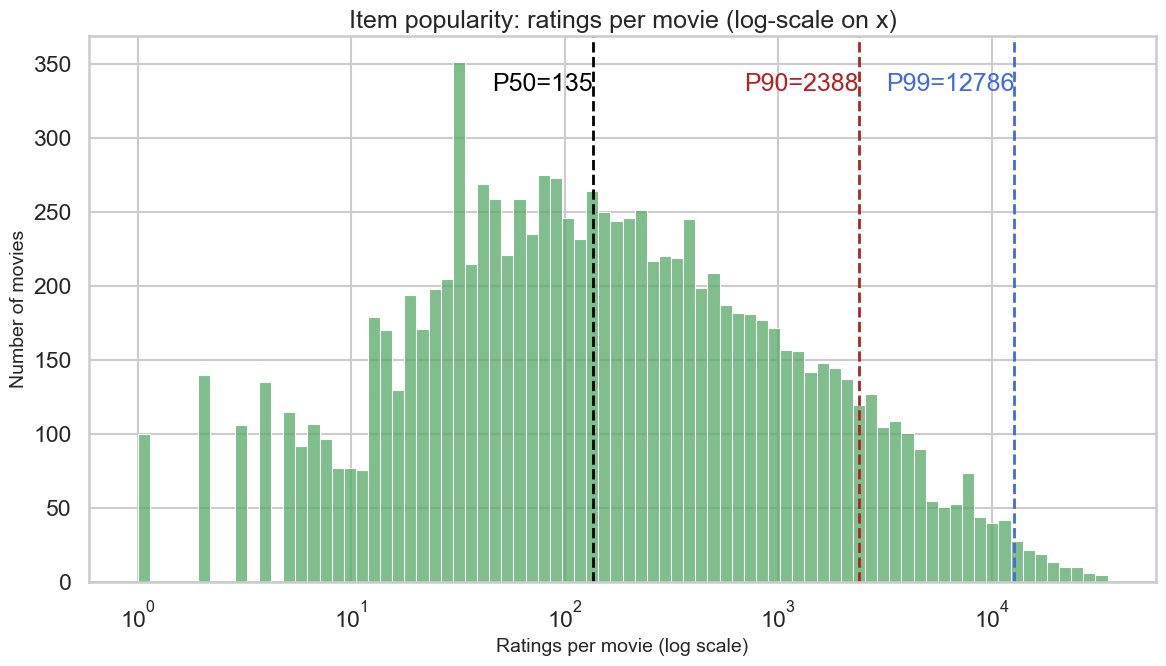

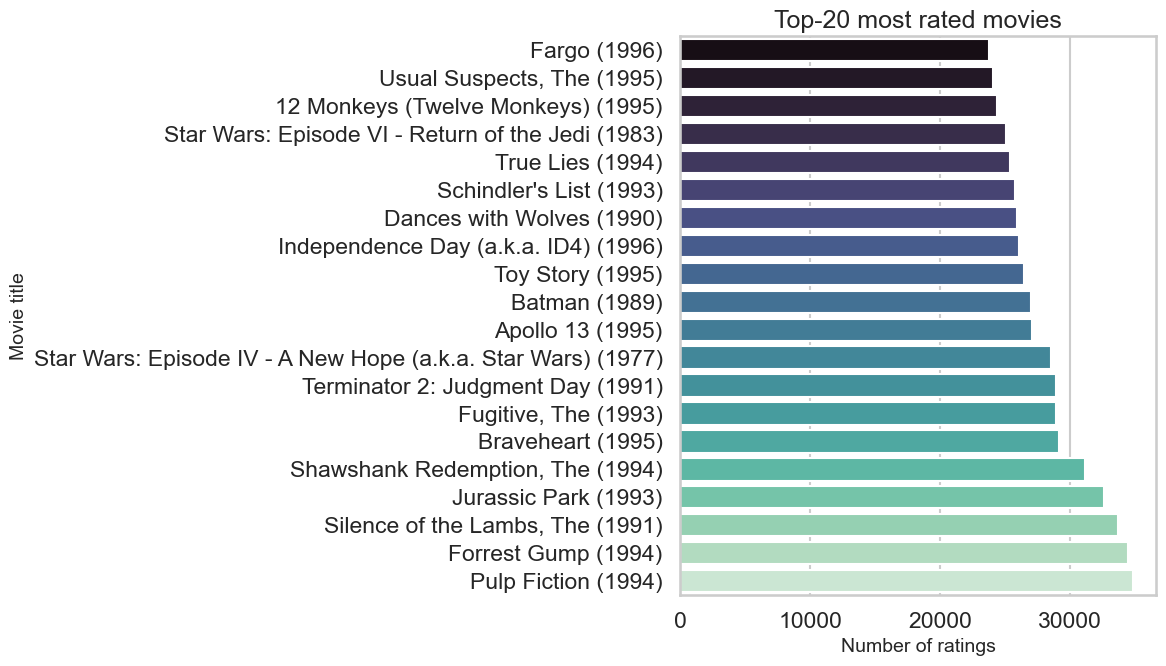

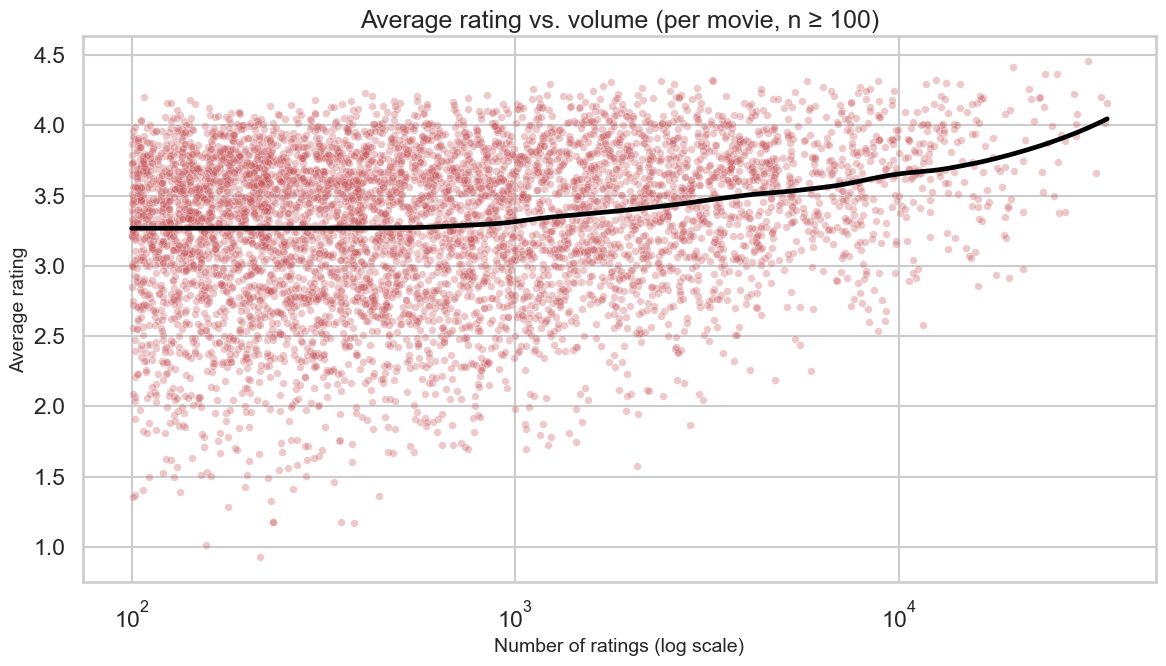

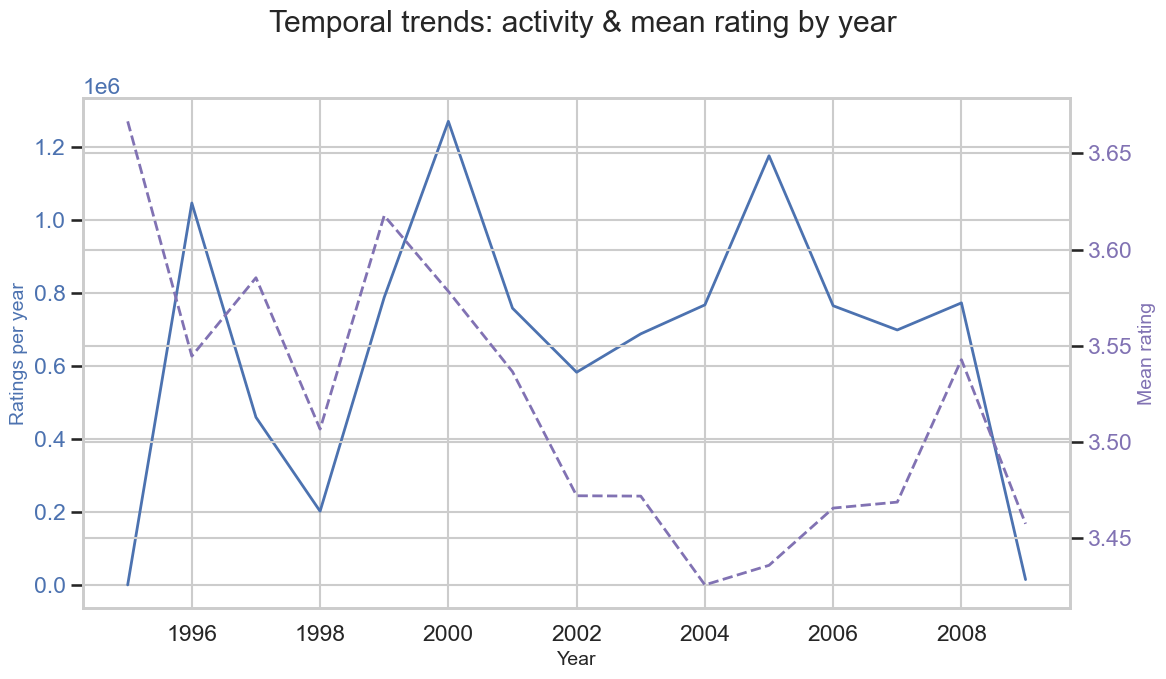

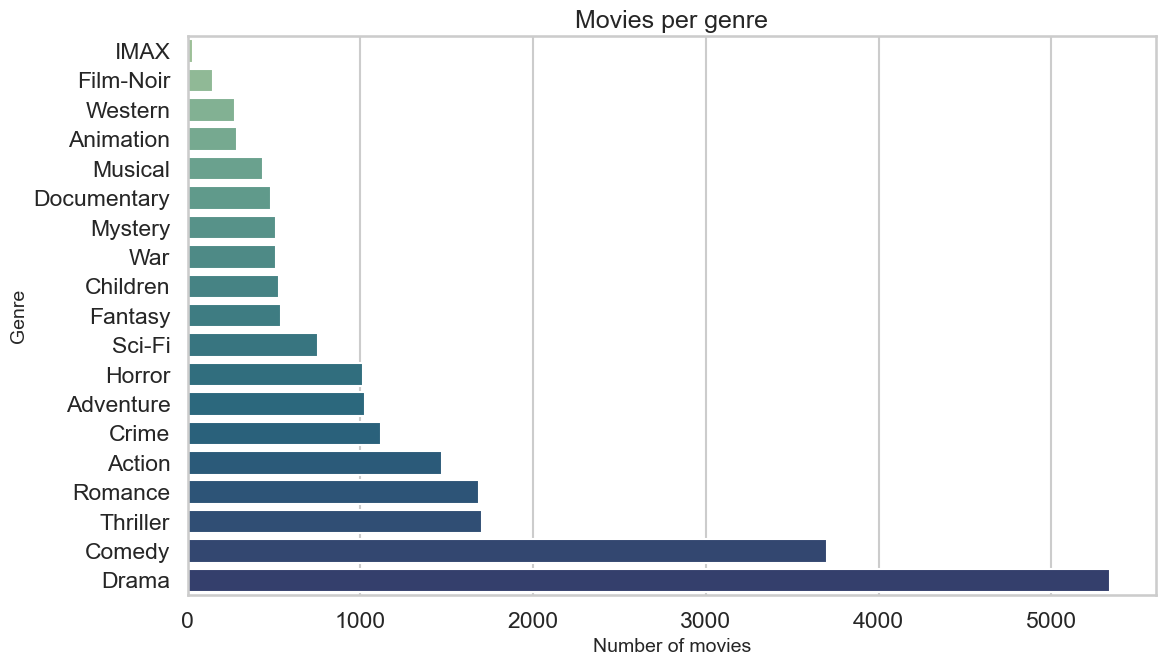

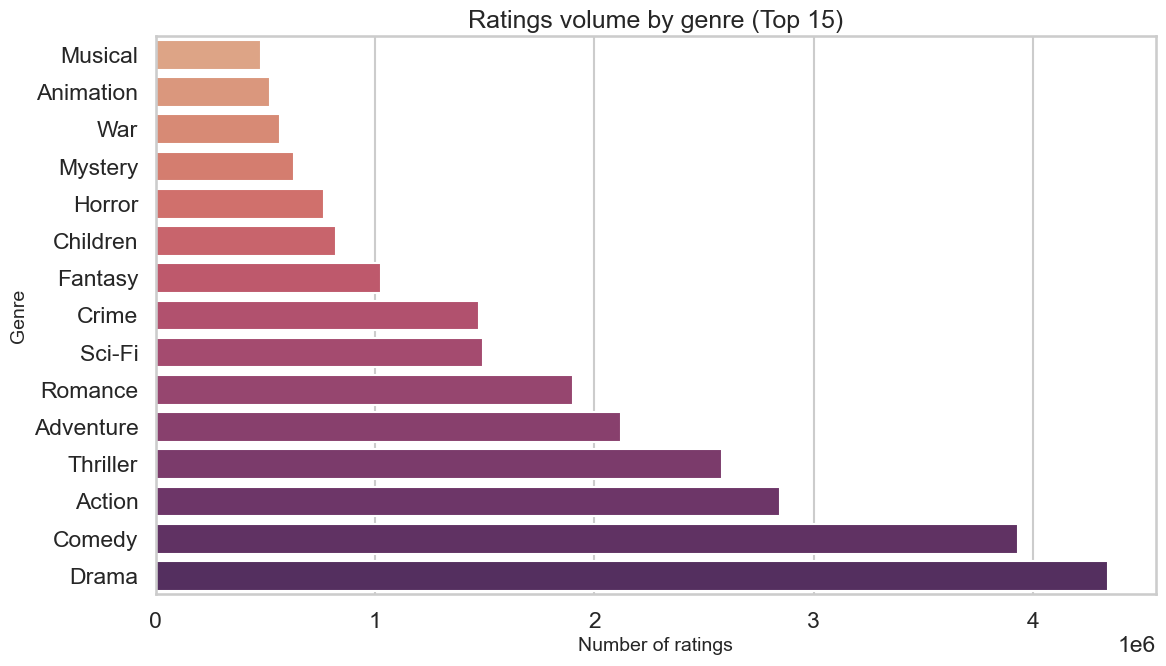

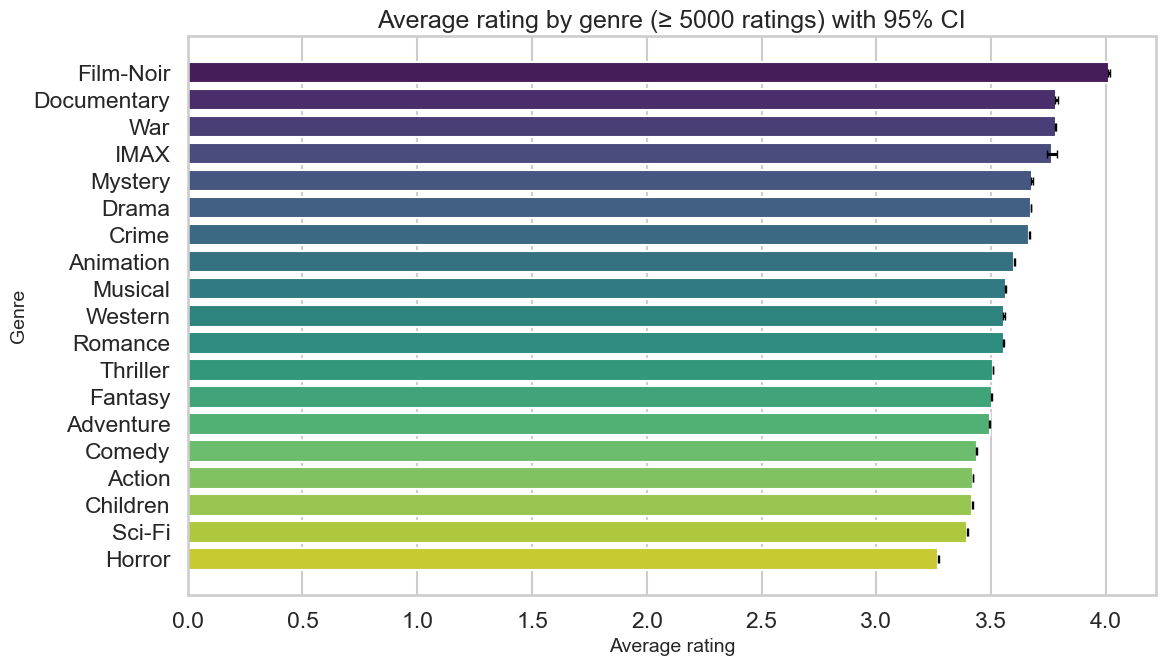

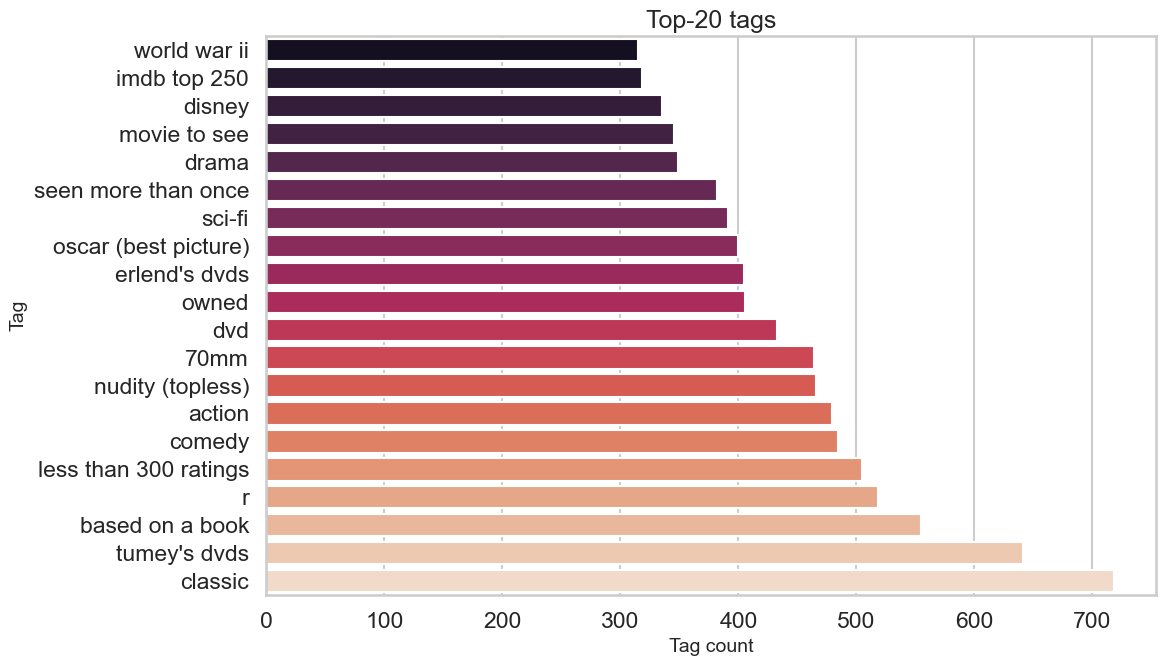


-- Sparsity --


,n_ratings,n_users,n_items,density
0,10000054,69878,10677,0.013403


Slide note: Density is typically very low in user–item matrices; this motivates collaborative methods and regularization.


In [25]:
# =============================================================================
# Title: MovieLens 10M - Slide-ready Visual Insights (Seaborn + DuckDB) [Fixed Seaborn v0.14 palette/hue deprecation]
# Description:
#   This single cell:
#     - Ensures required libs (seaborn, matplotlib, duckdb, pandas) are available
#     - Loads MovieLens 10M from .dat (UTF-8, '::') IF DuckDB tables are absent
#     - Runs DuckDB SQL to compute aggregated frames for plotting
#     - Produces slide-friendly charts with Seaborn (talk context, clean theme)
#     - Saves all figures to ./figs as high-resolution PNGs (300 DPI)
# Notes:
#   - Comments and section titles are in English, per request.
#   - Plots aligned with README’s key aspects (0.5–5.0 scale, genres, tags, temporal activity).
#   - IMPORTANT: For Seaborn >=0.14, when using a palette in barplot, we assign `hue=<y var>` and set `legend=False`.
# =============================================================================

# === 0) Setup & Imports =======================================================
import sys, os
# Install quietly if missing (Jupyter-friendly)
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError:
    get_ipython().run_line_magic('pip', 'install -q seaborn matplotlib')
    import seaborn as sns
    import matplotlib.pyplot as plt

try:
    import duckdb, pandas as pd, numpy as np
except ImportError:
    get_ipython().run_line_magic('pip', 'install -q duckdb pandas pyarrow')
    import duckdb, pandas as pd, numpy as np

# Aesthetics for slides
sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"]  = 14

# Output dir for figures
os.makedirs("figs", exist_ok=True)

# === 1) Data access: use existing DuckDB tables or load .dat ==================
# Paths (adjust if needed)
DATA_DIR   = r"C:\Users\mathe\Downloads\ml-10m\ml-10M100K"
PATH_RAT   = fr"{DATA_DIR}\ratings.dat"
PATH_MOV   = fr"{DATA_DIR}\movies.dat"
PATH_TAG   = fr"{DATA_DIR}\tags.dat"
DB_FILE    = "movielens.duckdb"

# Connect DuckDB
con = duckdb.connect(DB_FILE)

# Helper: check if tables exist
def table_exists(name: str) -> bool:
    try:
        con.execute(f"SELECT 1 FROM {name} LIMIT 1")
        return True
    except Exception:
        return False

ratings_ok = table_exists("ratings")
movies_ok  = table_exists("movies")
tags_ok    = table_exists("tags")

if not (ratings_ok and movies_ok and tags_ok):
    # --- Load .dat (UTF-8, '::') into pandas ---
    ratings = pd.read_csv(
        PATH_RAT, sep="::", engine="python", encoding="utf-8",
        names=["userId","movieId","rating","timestamp"]
    )
    movies = pd.read_csv(
        PATH_MOV, sep="::", engine="python", encoding="utf-8",
        names=["movieId","title","genres"]
    )
    tags = pd.read_csv(
        PATH_TAG, sep="::", engine="python", encoding="utf-8",
        names=["userId","movieId","tag","timestamp"]
    )

    # Dtypes for efficiency
    ratings["userId"]  = ratings["userId"].astype("int32")
    ratings["movieId"] = ratings["movieId"].astype("int32")
    ratings["rating"]  = ratings["rating"].astype("float32")
    # timestamps as int64

    movies["movieId"] = movies["movieId"].astype("int32")
    movies["title"]   = movies["title"].astype("string")
    movies["genres"]  = movies["genres"].astype("string")

    tags["userId"]    = tags["userId"].astype("int32")
    tags["movieId"]   = tags["movieId"].astype("int32")
    tags["tag"]       = tags["tag"].astype("string")
    # timestamps as int64

    # Register & persist
    con.register("ratings_df", ratings)
    con.register("movies_df", movies)
    con.register("tags_df", tags)
    con.execute("CREATE OR REPLACE TABLE ratings AS SELECT * FROM ratings_df")
    con.execute("CREATE OR REPLACE TABLE movies  AS SELECT * FROM movies_df")
    con.execute("CREATE OR REPLACE TABLE tags    AS SELECT * FROM tags_df")

# === 2) Helpful global overview (printed once) ================================
print("-- Overview (from README-consistent structure) --")
overview = con.execute("""
WITH
  c AS (SELECT COUNT(*) AS n_ratings FROM ratings),
  u AS (SELECT COUNT(DISTINCT userId) AS n_users FROM ratings),
  m AS (SELECT COUNT(*) AS n_movies FROM movies),
  t AS (SELECT COUNT(*) AS n_tags FROM tags)
SELECT c.n_ratings, u.n_users, m.n_movies, t.n_tags FROM c,u,m,t
""").df()
display(overview)

# =============================================================================
# PLOTS
# Each block computes an aggregated DataFrame in DuckDB and then plots with Seaborn.
# Figures are saved under ./figs with numbered filenames for slide insertion.
# =============================================================================

# --- Plot 01: Rating distribution (0.5 to 5.0) --------------------------------
# Purpose: Show how users utilize the 5-star scale with half-star increments.
df_rating_dist = con.execute("""
SELECT rating, COUNT(*) AS n
FROM ratings
GROUP BY rating
ORDER BY rating
""").df()

plt.figure()
ax = sns.barplot(data=df_rating_dist, x="rating", y="n", color=sns.color_palette()[0])  # OK: using 'color', not 'palette'
ax.set_title("Rating distribution (0.5–5.0)")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
# Optional: annotate bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10, rotation=90, xytext=(0,5), textcoords='offset points')
plt.tight_layout()
plt.savefig("figs/01_rating_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 02: Ratings per user (activity distribution) ------------------------
# Purpose: Highlight user activity skew; many users rate ~20+ items.
per_user = con.execute("""
SELECT userId, COUNT(*) AS n
FROM ratings
GROUP BY userId
""").df()

q50, q90, q99 = np.quantile(per_user["n"], [0.5, 0.9, 0.99])

plt.figure()
ax = sns.histplot(per_user, x="n", bins=80, log_scale=(True, False), color=sns.color_palette()[1])
ax.set_title("User activity: ratings per user (log-scale on x)")
ax.set_xlabel("Ratings per user (log scale)")
ax.set_ylabel("Number of users")
for q, lab, col in [(q50,"P50", "black"), (q90,"P90", "firebrick"), (q99,"P99", "royalblue")]:
    ax.axvline(q, color=col, linestyle="--", linewidth=2)
    ax.text(q, ax.get_ylim()[1]*0.9, f"{lab}={int(q)}", color=col, ha="right")
plt.tight_layout()
plt.savefig("figs/02_user_activity_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 03: Ratings per movie (popularity distribution) ---------------------
# Purpose: Show item popularity skew (few films get many ratings).
per_movie = con.execute("""
SELECT movieId, COUNT(*) AS n
FROM ratings
GROUP BY movieId
""").df()

mq50, mq90, mq99 = np.quantile(per_movie["n"], [0.5, 0.9, 0.99])

plt.figure()
ax = sns.histplot(per_movie, x="n", bins=80, log_scale=(True, False), color=sns.color_palette()[2])
ax.set_title("Item popularity: ratings per movie (log-scale on x)")
ax.set_xlabel("Ratings per movie (log scale)")
ax.set_ylabel("Number of movies")
for q, lab, col in [(mq50,"P50", "black"), (mq90,"P90","firebrick"), (mq99,"P99","royalblue")]:
    ax.axvline(q, color=col, linestyle="--", linewidth=2)
    ax.text(q, ax.get_ylim()[1]*0.9, f"{lab}={int(q)}", color=col, ha="right")
plt.tight_layout()
plt.savefig("figs/03_movie_popularity_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 04: Top-20 most rated movies ---------------------------------------
# Purpose: Names that drive most interactions; pair with average rating.
top_movies = con.execute("""
SELECT 
  r.movieId, m.title,
  COUNT(*) AS num_ratings,
  AVG(r.rating) AS mean_rating
FROM ratings r
JOIN movies m USING(movieId)
GROUP BY r.movieId, m.title
ORDER BY num_ratings DESC
LIMIT 20
""").df()

plt.figure()
ax = sns.barplot(
    data=top_movies.sort_values("num_ratings"),
    y="title", x="num_ratings",
    hue="title", palette="mako", legend=False  # FIX: add hue + legend=False
)
ax.set_title("Top-20 most rated movies")
ax.set_xlabel("Number of ratings")
ax.set_ylabel("Movie title")
plt.tight_layout()
plt.savefig("figs/04_top20_most_rated.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 05: Average rating vs #ratings (stability vs popularity) ------------
# Purpose: Show how mean rating stabilizes with more data; filter min n>=100.
avg_vs_n = con.execute("""
WITH agg AS (
  SELECT movieId, COUNT(*) AS n, AVG(rating) AS mean_rating
  FROM ratings
  GROUP BY movieId
)
SELECT * FROM agg WHERE n >= 100
""").df()

plt.figure()
ax = sns.scatterplot(
    data=avg_vs_n, x="n", y="mean_rating",
    alpha=0.3, s=30, color=sns.color_palette()[3]
)
sns.regplot(
    data=avg_vs_n, x="n", y="mean_rating",
    scatter=False, lowess=True, color="black"
)
ax.set_xscale("log")
ax.set_title("Average rating vs. volume (per movie, n ≥ 100)")
ax.set_xlabel("Number of ratings (log scale)")
ax.set_ylabel("Average rating")
plt.tight_layout()
plt.savefig("figs/05_mean_vs_volume.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 06: Temporal trends (volume & mean rating by year) ------------------
# Purpose: Evolution of rating activity and sentiment over time.
by_year = con.execute("""
SELECT 
  EXTRACT(YEAR FROM TO_TIMESTAMP(timestamp))::INT AS year,
  COUNT(*) AS n_ratings,
  AVG(rating) AS mean_rating
FROM ratings
GROUP BY year
HAVING year IS NOT NULL
ORDER BY year
""").df()

fig, ax1 = plt.subplots()
color1 = sns.color_palette()[0]
color2 = sns.color_palette()[4]

ax1.plot(by_year["year"], by_year["n_ratings"], color=color1, linewidth=2, label="Ratings per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Ratings per year", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.plot(by_year["year"], by_year["mean_rating"], color=color2, linewidth=2, linestyle="--", label="Mean rating")
ax2.set_ylabel("Mean rating", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
fig.suptitle("Temporal trends: activity & mean rating by year")
fig.tight_layout()
fig.savefig("figs/06_temporal_trends.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 07a: Genres - number of movies per genre ----------------------------
# Purpose: Genre coverage (catalog size per genre).
genre_movies = con.execute("""
WITH g AS (
  SELECT UNNEST(STR_SPLIT(genres, '|')) AS genre
  FROM movies
)
SELECT genre, COUNT(*) AS n_movies
FROM g
WHERE genre IS NOT NULL AND genre <> '(no genres listed)'
GROUP BY genre
ORDER BY n_movies DESC
""").df()

plt.figure()
ax = sns.barplot(
    data=genre_movies.sort_values("n_movies", ascending=True),
    y="genre", x="n_movies",
    hue="genre", palette="crest", legend=False  # FIX
)
ax.set_title("Movies per genre")
ax.set_xlabel("Number of movies")
ax.set_ylabel("Genre")
plt.tight_layout()
plt.savefig("figs/07a_genre_movies.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 07b: Genres - ratings volume by genre (Top 15) ----------------------
genre_stats = con.execute("""
WITH expl AS (
  SELECT r.rating, UNNEST(STR_SPLIT(m.genres, '|')) AS genre
  FROM ratings r 
  JOIN movies m USING (movieId)
),
agg AS (
  SELECT 
    genre,
    COUNT(*) AS n_ratings,
    AVG(rating) AS mean_rating,
    STDDEV_SAMP(rating) AS sd,
    COUNT(*)::DOUBLE AS n
  FROM expl
  WHERE genre IS NOT NULL AND genre <> '(no genres listed)'
  GROUP BY genre
)
SELECT genre, n_ratings, mean_rating, sd / SQRT(n) * 1.96 AS ci95
FROM agg
ORDER BY n_ratings DESC
""").df()

plt.figure()
ax = sns.barplot(
    data=genre_stats.sort_values("n_ratings", ascending=True).tail(15),
    y="genre", x="n_ratings",
    hue="genre", palette="flare", legend=False  # FIX
)
ax.set_title("Ratings volume by genre (Top 15)")
ax.set_xlabel("Number of ratings")
ax.set_ylabel("Genre")
plt.tight_layout()
plt.savefig("figs/07b_genre_volume.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 07c: Genres - average rating (with 95% CI) --------------------------
min_vol = 5000
mean_ci = genre_stats[genre_stats["n_ratings"] >= min_vol].copy().sort_values("mean_rating", ascending=False)

plt.figure()
ax = sns.barplot(
    data=mean_ci, y="genre", x="mean_rating",
    hue="genre", palette="viridis", legend=False  # FIX
)
# Add error bars manually for CI
for i, row in mean_ci.reset_index(drop=True).iterrows():
    ax.errorbar(x=row["mean_rating"], y=i, xerr=row["ci95"], ecolor="black", capsize=3, fmt="none")
ax.set_title(f"Average rating by genre (≥ {min_vol} ratings) with 95% CI")
ax.set_xlabel("Average rating")
ax.set_ylabel("Genre")
plt.tight_layout()
plt.savefig("figs/07c_genre_mean_ci.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot 08: Tags - top-20 most frequent ------------------------------------
top_tags = con.execute("""
SELECT LOWER(TRIM(tag)) AS tag_norm, COUNT(*) AS n
FROM tags
GROUP BY tag_norm
ORDER BY n DESC
LIMIT 20
""").df()

plt.figure()
ax = sns.barplot(
    data=top_tags.sort_values("n", ascending=True),
    y="tag_norm", x="n",
    hue="tag_norm", palette="rocket", legend=False  # FIX
)
ax.set_title("Top-20 tags")
ax.set_xlabel("Tag count")
ax.set_ylabel("Tag")
plt.tight_layout()
plt.savefig("figs/08_top_tags.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Bonus: Sparsity (printed metric) -----------------------------------------
sparsity = con.execute("""
WITH stats AS (
  SELECT 
    (SELECT COUNT(*) FROM ratings)               AS n_ratings,
    (SELECT COUNT(DISTINCT userId) FROM ratings) AS n_users,
    (SELECT COUNT(DISTINCT movieId) FROM ratings)AS n_items
)
SELECT 
  n_ratings, n_users, n_items,
  1.0 * n_ratings / (n_users * n_items) AS density
FROM stats
""").df()
print("\n-- Sparsity --")
display(sparsity)
print("Slide note: Density is typically very low in user–item matrices; this motivates collaborative methods and regularization.")

## What does this model predict?

**Task:** Predict the **explicit rating** (on a 0.5–5.0 scale) that a user would give to a movie.

**Prediction formula (Bias Baseline):**
\[
\hat{r}_{u,i} = \mu + b_u + b_i
\]
- **\(\mu\)** — Global average rating across all users and movies.  
- **\(b_u\)** — **User bias**: some users consistently rate higher/lower than average.  
- **\(b_i\)** — **Item (movie) bias**: some movies consistently receive higher/lower ratings.

---

## How is it trained? (high level)

We estimate **item** and **user** biases with **regularized** alternating updates:
- Fix \(b_u\), update \(b_i\) in closed form; then fix \(b_i\), update \(b_u\).  
- Repeat for a few epochs until convergence.  
- **Regularization (L2)** controls overfitting, especially for users/movies with few ratings.

Training uses a **user-wise 80/20 split**: each user’s ratings are randomly divided so the model sees ~80% for that user in training and predicts the remaining ~20%.

---

## What metrics and plots do we report?

**Metrics**
- **RMSE** (Root Mean Squared Error) on the test set  
- **MAE** (Mean Absolute Error) on the test set

**Diagnostic plots (slide‑ready)**
1. **Learning Curve** — RMSE vs. epoch (train sample vs. test sample)  
2. **Residuals Distribution** — histogram + KDE of \(r_{true} - \hat{r}\)  
3. **Predicted vs. True** — hexbin scatter with \(y=x\) reference line  
4. **Calibration** — mean true vs. mean predicted across prediction deciles  
5. **Error by True Rating** — MAE for each rating value (0.5 to 5.0)  
6. **Per‑User RMSE** — distribution of user‑level RMSE (sampled users)

> The code saves figures under `./figs/` (e.g., `09_learning_curve.png`, `10_residuals_hist.png`, …).

---

## Why is this useful?

- **Strong baseline** for explicit‑feedback recommendation tasks.  
- **Interpretable**: separates global tendency, user leniency/strictness, and movie popularity/quality effects.  
- **Fast and robust**: scales to large datasets and sets a clear yardstick for more complex models.

---

## Next steps (stronger models)

- **Matrix Factorization** (SVD / SVD++): capture user–item interactions.  
- **Temporal MF (TimeSVD++)**: model drift over time.  
- **Implicit ranking models** (e.g., BPR) for top‑N recommendation.  



-- SPLITS: (re)creating user-wise random 80/20 (rating_splits) --


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


-- SPLITS: (re)creating temporal 80/20 (rating_splits_time) --

-- SPLITS SUMMARY (random 80/20) --


,split,n,mean_rating
0,test,2027472,3.513062
1,train,7972582,3.512259



-- BASELINE MODEL: training with tracking (this may take ~tens of seconds) --
  epoch 1/8 | RMSE train(sample)=0.8582 | RMSE test(sample)=0.8650
  epoch 2/8 | RMSE train(sample)=0.8570 | RMSE test(sample)=0.8638
  epoch 3/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8636
  epoch 4/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8636
  epoch 5/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8636
  epoch 6/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8635
  epoch 7/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8635
  epoch 8/8 | RMSE train(sample)=0.8568 | RMSE test(sample)=0.8635

-- BASELINE FINAL METRICS (full test) --  RMSE: 0.8644 | MAE: 0.6689


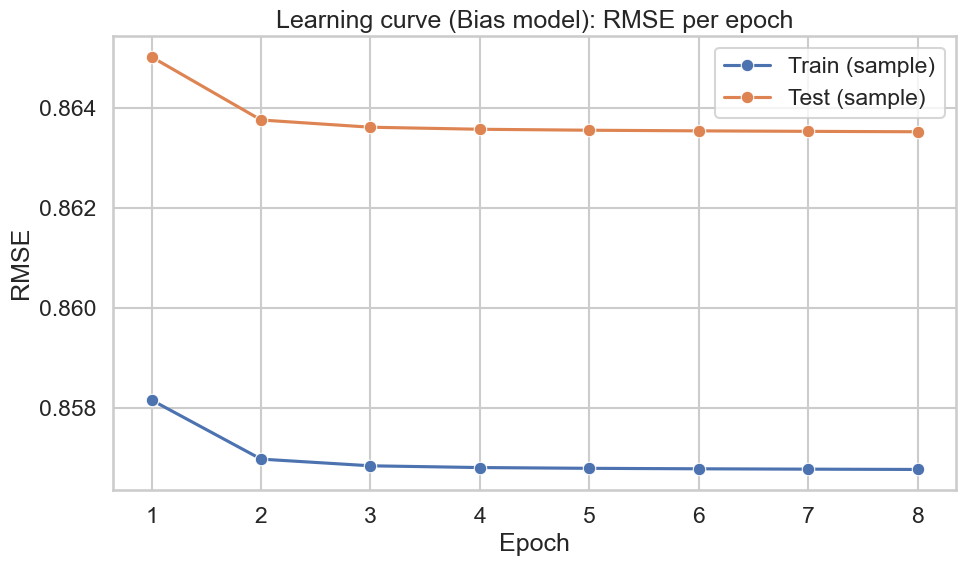

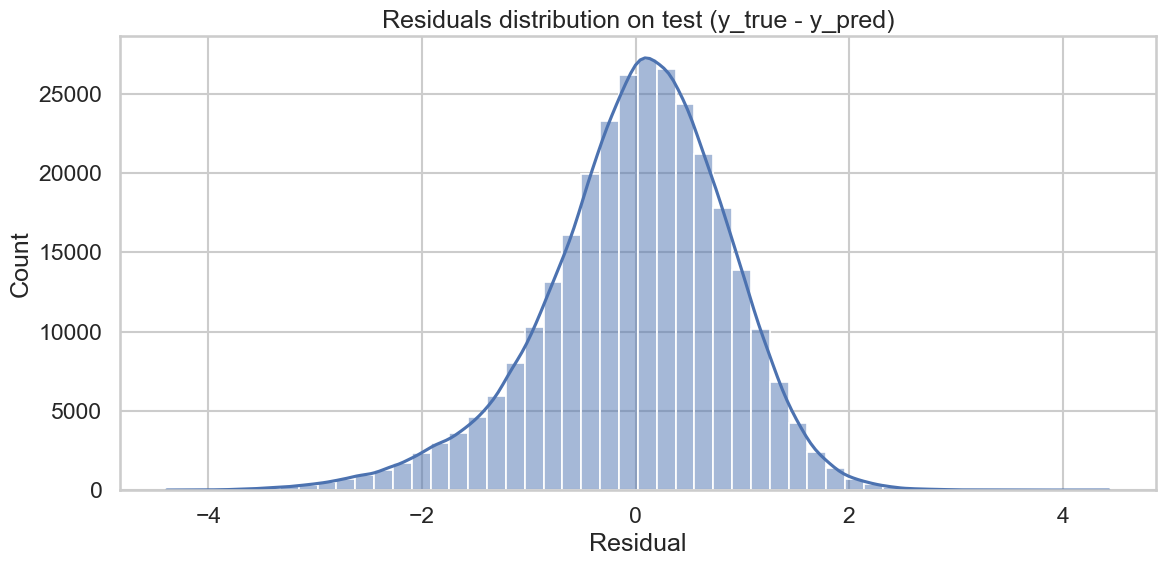

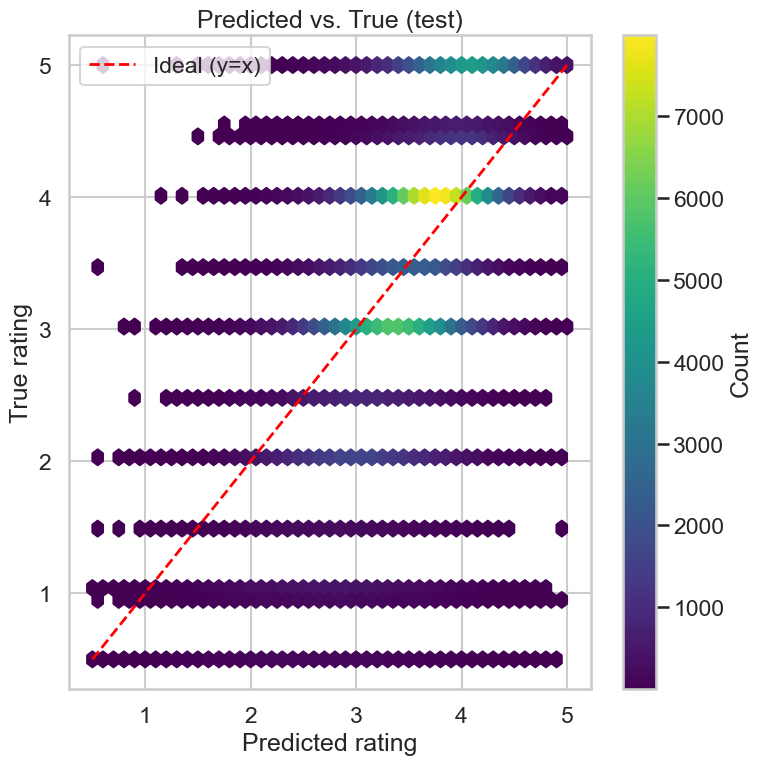

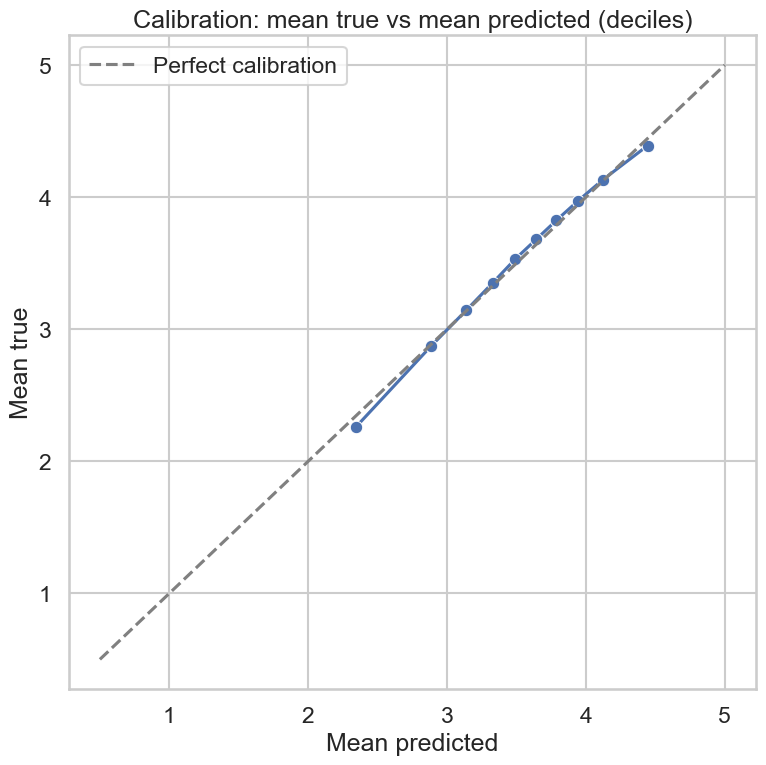

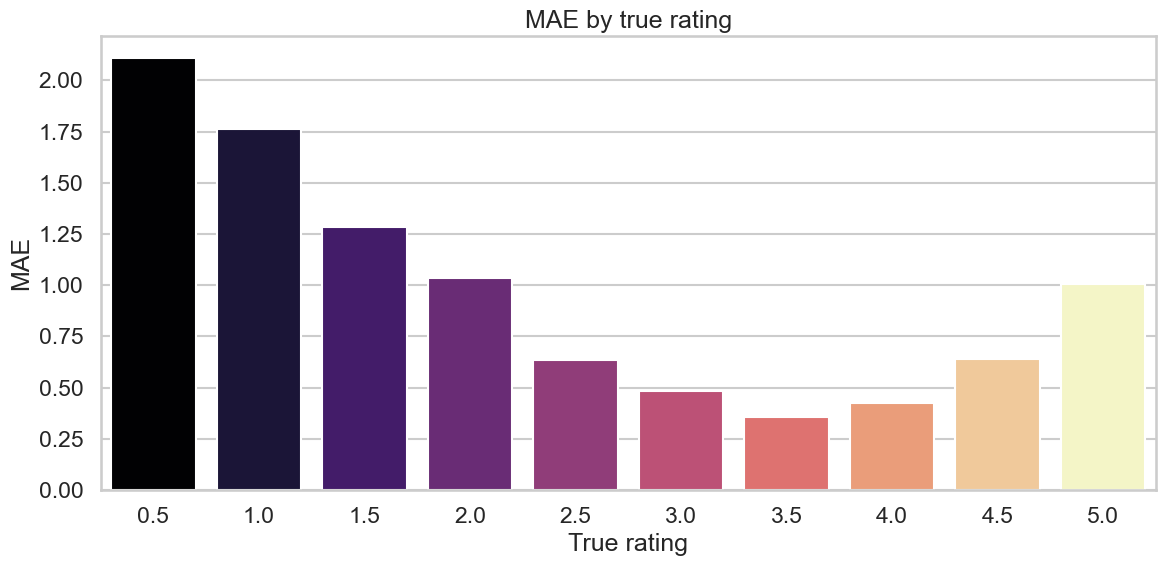

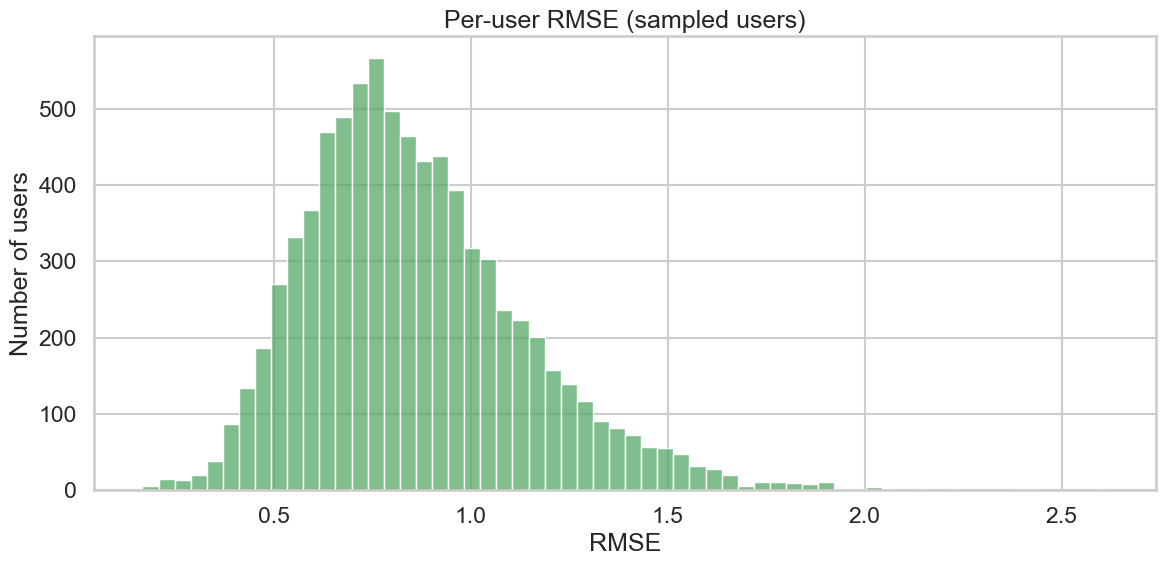


[Done] Figures saved to ./figs:
 - 01_rating_distribution.png
 - 02_user_activity_hist.png
 - 03_movie_popularity_hist.png
 - 04_top20_most_rated.png
 - 05_mean_vs_volume.png
 - 06_temporal_trends.png
 - 07a_genre_movies.png
 - 07b_genre_volume.png
 - 07c_genre_mean_ci.png
 - 08_top_tags.png
 - 09_learning_curve.png
 - 10_residuals_hist.png
 - 11_pred_vs_true_hexbin.png
 - 12_calibration_deciles.png
 - 13_error_by_true_rating.png
 - 14_rmse_per_user_hist.png


In [31]:
# =============================================================================
# Title: Bias Baseline + Splits (self-contained) with Performance Plots
# Description:
#   This single block:
#     - Ensures 'ratings' table exists (loaded previously)
#     - (Re)Creates 'rating_splits' and 'rating_splits_time' (80/20 per user)
#     - Trains a bias baseline (mu + b_i + b_u) with regularization
#     - Tracks RMSE per epoch and produces slide-ready plots
#     - Saves figures to ./figs
# =============================================================================

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb

sns.set_theme(style="whitegrid", context="talk", palette="deep")
os.makedirs("figs", exist_ok=True)

# --- Safety checks ------------------------------------------------------------
# Ensure 'ratings' exists (user must have run the data loading step before)
try:
    con.execute("SELECT 1 FROM ratings LIMIT 1")
except duckdb.CatalogException as e:
    raise RuntimeError(
        "Table 'ratings' not found. Run the data-loading cell that creates 'ratings', 'movies', and 'tags' first."
    ) from e

# --- (Re)Create splits (idempotent) -------------------------------------------
print("\n-- SPLITS: (re)creating user-wise random 80/20 (rating_splits) --")
con.execute("""
CREATE OR REPLACE TABLE rating_splits AS
WITH per_user AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY userId ORDER BY RANDOM()) AS rn,
    COUNT(*)     OVER (PARTITION BY userId)                    AS cnt
  FROM ratings
)
SELECT 
  userId, movieId, rating, timestamp,
  CASE WHEN rn <= 0.8 * cnt THEN 'train' ELSE 'test' END AS split
FROM per_user
""")

print("\n-- SPLITS: (re)creating temporal 80/20 (rating_splits_time) --")
con.execute("""
CREATE OR REPLACE TABLE rating_splits_time AS
WITH per_user AS (
  SELECT
    *,
    ROW_NUMBER() OVER (PARTITION BY userId ORDER BY timestamp) AS rn,
    COUNT(*)     OVER (PARTITION BY userId)                    AS cnt
  FROM ratings
)
SELECT 
  userId, movieId, rating, timestamp,
  CASE WHEN rn <= 0.8 * cnt THEN 'train' ELSE 'test' END AS split
FROM per_user
""")

# Quick sanity check (random split)
print("\n-- SPLITS SUMMARY (random 80/20) --")
display(con.execute("""
SELECT split, COUNT(*) AS n, AVG(rating) AS mean_rating
FROM rating_splits
GROUP BY split
ORDER BY split
""").df())

# === Baseline predictive model: global mean + item bias + user bias ===========
# The model predicts r_hat = mu + b_i + b_u with L2 regularization.
print("\n-- BASELINE MODEL: training with tracking (this may take ~tens of seconds) --")

split_df = con.execute("SELECT * FROM rating_splits").df()
train = split_df[split_df['split'] == 'train'][['userId','movieId','rating']].copy()
test  = split_df[split_df['split'] == 'test' ][['userId','movieId','rating']].copy()

# Global mean
mu = train['rating'].mean()

# Initialize biases
bu = pd.Series(0.0, index=train['userId'].unique(), dtype='float32')   # user bias
bi = pd.Series(0.0, index=train['movieId'].unique(), dtype='float32')  # item bias

# Regularization
reg = 10.0
EPOCHS = 8
RATING_MIN, RATING_MAX = 0.5, 5.0

# Sampling for fast per-epoch tracking
N_TRAIN_SAMPLE = 200_000
N_TEST_SAMPLE  = 200_000
train_sample = train.sample(n=min(N_TRAIN_SAMPLE, len(train)), random_state=42)
test_sample  = test.sample(n=min(N_TEST_SAMPLE,  len(test)),  random_state=42)

def rmse_fast(y_true, y_pred):
    diff = y_true.astype('float32') - y_pred.astype('float32')
    return float(np.sqrt(np.mean(diff * diff)))

rmse_hist_train_sample, rmse_hist_test_sample = [], []

for epoch in range(EPOCHS):
    # --- Update item biases (b_i) given current user biases ---
    bu_map = train['userId'].map(bu).fillna(0.0).astype('float32')
    res_i  = train['rating'] - mu - bu_map
    tmp_i  = pd.DataFrame({'movieId': train['movieId'].values, 'res': res_i.values})
    agg_i  = tmp_i.groupby('movieId', sort=False).agg(sum_res=('res','sum'), count=('res','size'))
    bi     = (agg_i['sum_res'] / (reg + agg_i['count'])).astype('float32')

    # --- Update user biases (b_u) given current item biases ---
    bi_map = train['movieId'].map(bi).fillna(0.0).astype('float32')
    res_u  = train['rating'] - mu - bi_map
    tmp_u  = pd.DataFrame({'userId': train['userId'].values, 'res': res_u.values})
    agg_u  = tmp_u.groupby('userId', sort=False).agg(sum_res=('res','sum'), count=('res','size'))
    bu     = (agg_u['sum_res'] / (reg + agg_u['count'])).astype('float32')

    # --- Per-epoch tracking on samples (speed) ---
    yhat_tr = (mu
               + train_sample['userId'].map(bu).fillna(0.0).astype('float32')
               + train_sample['movieId'].map(bi).fillna(0.0).astype('float32')).clip(RATING_MIN, RATING_MAX)
    yhat_te = (mu
               + test_sample['userId'].map(bu).fillna(0.0).astype('float32')
               + test_sample['movieId'].map(bi).fillna(0.0).astype('float32')).clip(RATING_MIN, RATING_MAX)

    rmse_tr = rmse_fast(train_sample['rating'], yhat_tr)
    rmse_te = rmse_fast(test_sample['rating'],  yhat_te)
    rmse_hist_train_sample.append(rmse_tr)
    rmse_hist_test_sample.append(rmse_te)
    print(f"  epoch {epoch+1}/{EPOCHS} | RMSE train(sample)={rmse_tr:.4f} | RMSE test(sample)={rmse_te:.4f}")

# --- Final metrics on full test set ---
yhat_full = (mu
             + test['userId'].map(bu).fillna(0.0).astype('float32')
             + test['movieId'].map(bi).fillna(0.0).astype('float32')).clip(RATING_MIN, RATING_MAX)
rmse_full = rmse_fast(test['rating'], yhat_full)
mae_full  = float(np.mean(np.abs(test['rating'] - yhat_full)))
print(f"\n-- BASELINE FINAL METRICS (full test) --  RMSE: {rmse_full:.4f} | MAE: {mae_full:.4f}")

# Store predictions for plots
test_eval = test.copy()
test_eval['y_pred'] = yhat_full.values
test_eval['resid']  = (test_eval['rating'] - test_eval['y_pred']).astype('float32')

# For heavy plots, sample for speed
PLOT_SAMPLE = 300_000
plot_df = test_eval.sample(n=min(PLOT_SAMPLE, len(test_eval)), random_state=7).copy()

# === Performance plots ========================================================
# 1) Learning curve (RMSE per epoch)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(1, EPOCHS+1), y=rmse_hist_train_sample, marker="o", label="Train (sample)")
sns.lineplot(x=np.arange(1, EPOCHS+1), y=rmse_hist_test_sample,  marker="o", label="Test (sample)")
plt.title("Learning curve (Bias model): RMSE per epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.xticks(np.arange(1, EPOCHS+1))
plt.legend()
plt.tight_layout()
plt.savefig("figs/09_learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Residuals distribution
plt.figure(figsize=(12,6))
sns.histplot(plot_df['resid'], bins=50, kde=True, color=sns.color_palette()[0])
plt.title("Residuals distribution on test (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figs/10_residuals_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# 3) Predicted vs. True (hexbin) + y=x
plt.figure(figsize=(8,8))
plt.hexbin(plot_df['y_pred'], plot_df['rating'], gridsize=45, cmap='viridis', mincnt=1)
cb = plt.colorbar(); cb.set_label('Count')
plt.plot([RATING_MIN, RATING_MAX], [RATING_MIN, RATING_MAX], '--', color='red', linewidth=2, label='Ideal (y=x)')
plt.title("Predicted vs. True (test)")
plt.xlabel("Predicted rating")
plt.ylabel("True rating")
plt.legend()
plt.tight_layout()
plt.savefig("figs/11_pred_vs_true_hexbin.png", dpi=300, bbox_inches="tight")
plt.show()

# 4) Calibration by prediction deciles
cal = (plot_df
       .assign(pred_bin=pd.qcut(plot_df['y_pred'], q=10, duplicates='drop'))
       .groupby('pred_bin', observed=True)
       .agg(mean_pred=('y_pred','mean'), mean_true=('rating','mean'), n=('rating','size'))
       .reset_index())

plt.figure(figsize=(8,8))
sns.lineplot(data=cal, x="mean_pred", y="mean_true", marker="o")
plt.plot([RATING_MIN, RATING_MAX], [RATING_MIN, RATING_MAX], '--', color='gray', label='Perfect calibration')
plt.title("Calibration: mean true vs mean predicted (deciles)")
plt.xlabel("Mean predicted")
plt.ylabel("Mean true")
plt.legend()
plt.tight_layout()
plt.savefig("figs/12_calibration_deciles.png", dpi=300, bbox_inches="tight")
plt.show()

# 5) Error by true rating (MAE)
err_by_true = (test_eval
               .assign(abs_err=(test_eval['rating'] - test_eval['y_pred']).abs())
               .groupby('rating', as_index=False)['abs_err'].mean()
               .rename(columns={'abs_err':'mae'}))

plt.figure(figsize=(12,6))
# seaborn>=0.14: palette + hue (no deprecation warning)
sns.barplot(data=err_by_true, x="rating", y="mae", hue="rating", palette="magma", legend=False)
plt.title("MAE by true rating")
plt.xlabel("True rating")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig("figs/13_error_by_true_rating.png", dpi=300, bbox_inches="tight")
plt.show()

# 6) Per-user RMSE distribution (sampled users)
USER_SAMPLE = 8000
users_sample = test_eval['userId'].drop_duplicates().sample(
    n=min(USER_SAMPLE, test_eval['userId'].nunique()), random_state=123
)
per_user_rmse = (test_eval[test_eval['userId'].isin(users_sample)]
                 .assign(se=(test_eval['rating'] - test_eval['y_pred'])**2)
                 .groupby('userId', as_index=False)['se'].mean())
per_user_rmse['rmse'] = np.sqrt(per_user_rmse['se'].astype('float32'))

plt.figure(figsize=(12,6))
sns.histplot(per_user_rmse['rmse'], bins=60, color=sns.color_palette()[2])
plt.title("Per-user RMSE (sampled users)")
plt.xlabel("RMSE")
plt.ylabel("Number of users")
plt.tight_layout()
plt.savefig("figs/14_rmse_per_user_hist.png", dpi=300, bbox_inches="tight")
plt.show()

# List saved figures (safe)
try:
    files = []
    if os.path.isdir("figs"):
        files = sorted([p for p in os.listdir("figs") if p.lower().endswith((".png", ".svg", ".pdf"))])
    print("\n[Done] Figures saved to ./figs:")
    if files:
        for name in files:
            print(f" - {name}")
    else:
        print(" - (no figure files found)")
except Exception as e:
    print("\n[Note] Could not list figures, but plots should be saved. Error:", e)